In [1]:
from FastCCM import CCM, CCM_utils
from FastCCM.utils import utils
import numpy as np
import matplotlib.pyplot as plt
import pyEDM
import pandas as pd 

In [2]:
ccm = CCM.PairwiseCCM(device="cpu")

In [3]:
X_to_Y_res_FastCCM = []
Y_to_X_res_FastCCM = []
X_to_Y_res_pyEDM = []
Y_to_X_res_pyEDM = []

for _ in range(100):
    X = np.random.normal(0,1,500)
    Y = np.random.uniform(0,1,500)
    df = pd.DataFrame([X,Y],index=["X","Y"]).T

    X_emb = np.transpose(utils.get_td_embedding_np(X[:,None],3,1),(2,0,1))
    Y_emb = np.transpose(utils.get_td_embedding_np(Y[:,None],3,1),(2,0,1))

    conv_test_res_FastCCM = CCM_utils.Functions("cpu").convergence_test(X = X_emb,
                                                                Y = Y_emb,
                                        subset_sizes = [100, 200, 300, 400, 500],
                                        subsample_size=1000, exclusion_rad=5, tp=0, method="simplex",trials=10)

    conv_test_res_pyEDM = pyEDM.CCM(df,columns="X",target="Y",libSizes="100 500 100", sample=10, E=3, tau=-1, exclusionRadius=4).to_numpy()

    X_to_Y_res_FastCCM += [conv_test_res_FastCCM['X_to_Y'][:,:,-1,0].mean(axis=1)[-1][0]]
    Y_to_X_res_FastCCM += [conv_test_res_FastCCM['Y_to_X'][:,:,-1,0].mean(axis=1)[-1][0]]
    X_to_Y_res_pyEDM += [conv_test_res_pyEDM[-1,1]]
    Y_to_X_res_pyEDM += [conv_test_res_pyEDM[-1,2]]


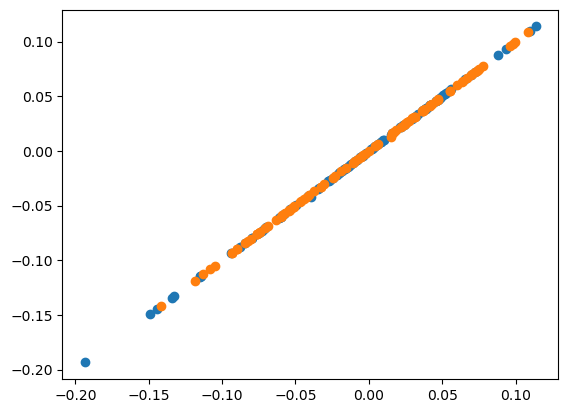

In [4]:
plt.scatter(X_to_Y_res_FastCCM, X_to_Y_res_pyEDM)
plt.scatter(Y_to_X_res_FastCCM, Y_to_X_res_pyEDM)